# Front Matter: CASA0013: Foundations of Spatial Data Science

## Clusters of Potential Misuse

### Student ID: 21197822

### Word Count: 1507 (including in-line citations)

# Reproducible Analysis

My Github will not allow me to upload the following files due to file size. Please download, unzip, and save the following files and folders in a folder called 'data' in the same directory as this reproducible analysis. I apologise for the inconvenience and hope my efforts in the code may still be viewed.

Inside Airbnb Data
http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz

MSOA boundary shapefile
https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip

MSOA 2011 Census Data
https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls


### Import Packages

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy as sp
import scipy.stats as sps

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import matplotlib.cm as cm
import seaborn as sns

#import re
import os

#from matplotlib.colors import ListedColormap

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

#import statsmodels.formula.api as smf
#import statsmodels.api as sm
#from statsmodels.stats.outliers_influence import variance_inflation_factor 
#from statsmodels.tools.tools import add_constant

### Airbnb Data

In [2]:
# Load Airbnb Data as dataframe
# Source: http://insideairbnb.com/get-the-data.html
# URL download: http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz
air0 = pd.read_csv(os.path.join('data', '2021-10-10-listings.csv'), low_memory=False, na_values= 'NaN') #usecols=cols,
#air0 = pd.read_csv('https://docs.google.com/spreadsheets/d/1nK4tmQXWbaOmsPCmr3QM0S3-Yk1u9brH/edit?usp=sharing&ouid=114217418819259890890&rtpof=true&sd=true',
                   #low_memory=False, na_values= 'NaN')

print(air0.shape)

(67903, 74)


### Subset and Clean Data

In [3]:
# Identify columns to keep, including ten variables to analyze
to_keep = ['id', 'latitude', 'longitude', # id and location              
           
           # Misuse variables from literature
           'availability_365', # Criteria 1
           'room_type', # Criteria 2
           'calculated_host_listings_count', # Criteria 3
           'reviews_per_month', 
           'price',
           'host_since',
           
           # Additional variables from airbnb
           'host_acceptance_rate',
           'instant_bookable', 
           'review_scores_value',          
           'minimum_nights', 
           'maximum_nights']

# Subset these columns of airbnb dataframe
air = air0[to_keep].copy()

# Check Subset
print(air.columns.get_level_values(0))
print(air.shape)

Index(['id', 'latitude', 'longitude', 'availability_365', 'room_type',
       'calculated_host_listings_count', 'reviews_per_month', 'price',
       'host_since', 'host_acceptance_rate', 'instant_bookable',
       'review_scores_value', 'minimum_nights', 'maximum_nights'],
      dtype='object')
(67903, 14)


In [4]:
######## Clean variable columns, printing remaining rows to monitor number of observations dropped

print(air.shape[0], "starting number of rows")

### Clean id and location columns

air.id.unique()
print(air.shape[0], "rows remaining after dropping duplicates from 'id'")

air.drop(index=air[ (air.id.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'id'")

air.drop(index=air[ (air.latitude.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'latitude'")

air.drop(index=air[ (air.longitude.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'longitude'")



### Clean variables relating to definition of 'misuse' 

air.drop(index=air[ (air.availability_365.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'availability_365'")

air.drop(index=air[ (air.room_type.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'room_type'")

air.drop(index=air[ (air.calculated_host_listings_count.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'calculated_host_listings_count'")

air.drop(index=air[ (air.reviews_per_month.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'reviews_per_month'")

air['price'] = air.price.str.replace('$','').str.replace(',','').astype(float)
print(air.shape[0], "rows remaining after dropping '$' from 'price'")

air.drop(index=air[ air.price.isna() ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'price'")

air.drop(index=air[ air.host_since.isna() ].index, inplace=True)
air[['host_since','date']] = air.host_since.apply(str).str.split('-', 1, expand=True)
air.drop(['date'], axis=1, inplace = True)
air['host_since'] = 2022 - air.host_since.apply(int)
# https://cmdlinetips.com/2018/11/how-to-split-a-text-column-in-pandas/
print(air.shape[0], "rows remaining after dropping NaN's from 'host_since'")

#### Clean additional variables from airbnb

air['host_acceptance_rate'] = air.host_acceptance_rate.str.replace('%','')
print(air.shape[0], "rows remaining after dropping '%' from 'host_acceptance_rate'")

air.drop(index=air[ (air.host_acceptance_rate.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'host_acceptance_rate'")

air['host_acceptance_rate'] = air.host_acceptance_rate.astype('int') /100
print(air.shape[0], "rows remaining after converting to numeric 'host_acceptance_rate'")

air.drop(index=air[ (air.instant_bookable.isna()) ].index, inplace=True)
air['instant_bookable'] = air.instant_bookable.replace('t',1).replace('f',0)
print(air.shape[0], "rows remaining after dropping NaN's from 'instant_bookable'")

air.drop(index=air[ (air.review_scores_value.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'review_scores_value'")

air.drop(index=air[ (air.minimum_nights.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'minimum_nights'")

air.drop(index=air[ (air.maximum_nights.isna()) ].index, inplace=True)
print(air.shape[0], "rows remaining after dropping NaN's from 'maximum_nights'")

67903 starting number of rows
67903 rows remaining after dropping duplicates from 'id'
67903 rows remaining after dropping NaN's from 'id'
67903 rows remaining after dropping NaN's from 'latitude'
67903 rows remaining after dropping NaN's from 'longitude'
67903 rows remaining after dropping NaN's from 'availability_365'
67903 rows remaining after dropping NaN's from 'room_type'
67903 rows remaining after dropping NaN's from 'calculated_host_listings_count'
48875 rows remaining after dropping NaN's from 'reviews_per_month'
48875 rows remaining after dropping '$' from 'price'
48875 rows remaining after dropping NaN's from 'price'


/tmp/ipykernel_220/4109639220.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  air['price'] = air.price.str.replace('$','').str.replace(',','').astype(float)


48858 rows remaining after dropping NaN's from 'host_since'
48858 rows remaining after dropping '%' from 'host_acceptance_rate'
26633 rows remaining after dropping NaN's from 'host_acceptance_rate'
26633 rows remaining after converting to numeric 'host_acceptance_rate'
26633 rows remaining after dropping NaN's from 'instant_bookable'
26406 rows remaining after dropping NaN's from 'review_scores_value'
26406 rows remaining after dropping NaN's from 'minimum_nights'
26406 rows remaining after dropping NaN's from 'maximum_nights'


In [5]:
# check if there are any remaining NA's
air.isnull().sum(axis=0).sort_values(ascending=False)

id                                0
latitude                          0
longitude                         0
availability_365                  0
room_type                         0
calculated_host_listings_count    0
reviews_per_month                 0
price                             0
host_since                        0
host_acceptance_rate              0
instant_bookable                  0
review_scores_value               0
minimum_nights                    0
maximum_nights                    0
dtype: int64

### Convert to Geodata

<AxesSubplot:>

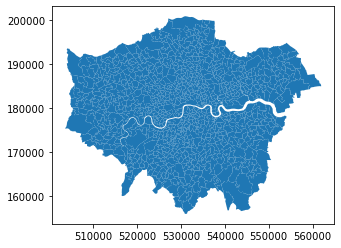

In [6]:
# Load spatial unit: MSOA Boundaries, 2011
# Source: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
# https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip
spunit = gpd.read_file(os.path.join('data', 'statistical-gis-boundaries-london', 
                                'ESRI', 'MSOA_2011_London_gen_MHW.shp'))
spunit.plot()

['id' 'latitude' 'longitude' 'availability_365' 'room_type'
 'calculated_host_listings_count' 'reviews_per_month' 'price' 'host_since'
 'host_acceptance_rate' 'instant_bookable' 'review_scores_value'
 'minimum_nights' 'maximum_nights' 'geometry' 'index_right' 'MSOA11CD'
 'MSOA11NM' 'LAD11CD' 'LAD11NM' 'RGN11CD' 'RGN11NM' 'USUALRES' 'HHOLDRES'
 'COMESTRES' 'POPDEN' 'HHOLDS' 'AVHHOLDSZ']
(26406, 28)


<AxesSubplot:>

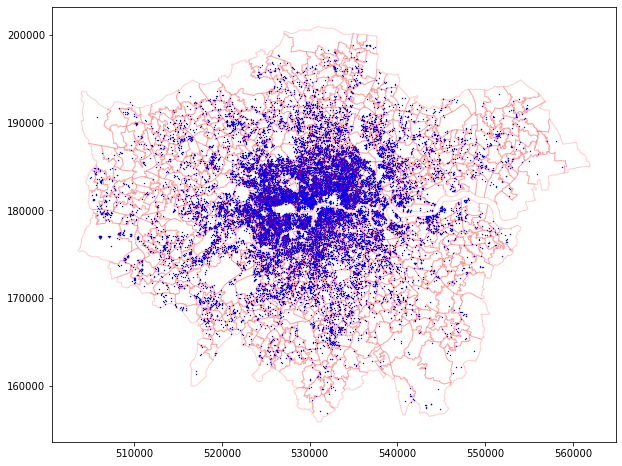

In [7]:
# Convert airbnb dataframe into a geodataframe
gdf = gpd.GeoDataFrame(air, geometry=gpd.points_from_xy(air.longitude, air.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf = gdf.to_crs('epsg:27700')

# Reproject spatial. units to match just in case
spunit = spunit.to_crs('epsg:27700')

# Check projections
# print(spunit.geometry.crs)
# print(gdf.geometry.crs)

# Spatial join spunit and Airbnb listings
gdf = gpd.sjoin(gdf, spunit, op='within', how='left')
print(gdf.columns.values)
print(gdf.shape)

# Map listings against spunit
ax = gdf.plot(figsize=(12,8), marker='*', color='b', markersize=0.25)
spunit.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.2)

(26397, 28)


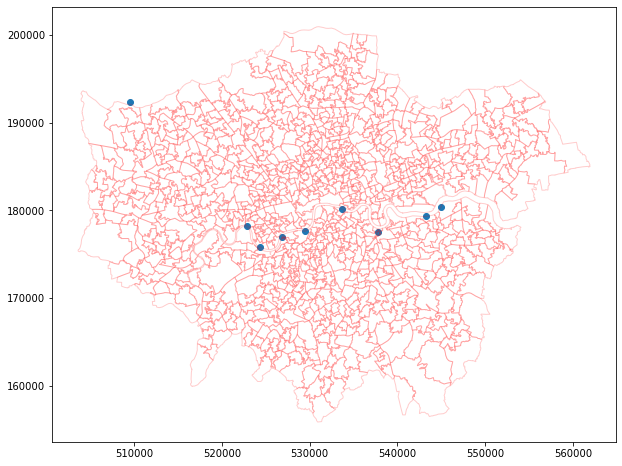

In [8]:
# identify listings outside London LSOA boundaries
ax = gdf[gdf.MSOA11CD.isna()].plot(figsize=(12,8))
spunit.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.2)

# drop those listings outside London LSOA boundaries
gdf.drop(index=gdf[gdf.MSOA11CD.isna()].index, axis=1, inplace=True)
print(gdf.shape)

### Clean and Subset Joined Geodata

In [9]:
# Make a copy of gdf for further processing (named 'mair' for msoas + airbnb listings)
gair = gdf.copy()
print(gair.shape[0], "rows before misuse subset")

26397 rows before misuse subset


In [10]:
### Misuse Listings Subsetting

# Offered for more than 180 days cumulatively
gair.drop(index=gair[ (gair.availability_365 > 180) ].index, inplace=True)
print(gair.shape[0], "after Criteria 1 is applied")

# Entire home
gair.drop(index=gair[ (gair.room_type == 'Entire home/apt') ].index, inplace=True)
print(gair.shape[0], "after Criteria 2 is applied")

print(gair.shape[0], "rows after misuse subset")

16527 after Criteria 1 is applied
5967 after Criteria 2 is applied
5967 rows after misuse subset


In [11]:
# Standardise by spatial unit over London totals

gar = gair.groupby('MSOA11CD').agg({'id': 'count', 
                                    'availability_365': 'sum',
                                    'calculated_host_listings_count': 'sum',
                                    'reviews_per_month': 'sum',
                                    'price': 'sum',
                                    'host_since': 'sum',
                                    'instant_bookable': 'sum',
                                    'host_acceptance_rate': 'sum',
                                    'review_scores_value': 'sum',
                                    'minimum_nights': 'sum',
                                    'maximum_nights': 'sum'})

gart = gair.agg({'id': 'count', 
                 'availability_365': 'sum',
                 'calculated_host_listings_count': 'sum',
                 'reviews_per_month': 'sum',
                 'price': 'sum',
                 'host_since': 'sum',
                 'instant_bookable': 'sum',
                 'host_acceptance_rate': 'sum',
                 'review_scores_value': 'sum',
                 'minimum_nights': 'sum',
                 'maximum_nights': 'sum'})

gars = gar.copy()
for column in gars:
    gars[column] = gars[column].div( float(gart[column]) )
gars=gars.reset_index()

### Census Data

In [12]:
# Source: https://data.london.gov.uk/dataset/msoa-atlas
# https://data.london.gov.uk/download/msoa-atlas/39fdd8eb-e977-4d32-85a4-f65b92f29dcb/msoa-data.xls
census0 = pd.read_excel(os.path.join('data', 'msoa-data.xls'),
    sheet_name='iadatasheet1', # Which sheet is the data in?
    header=[0,1,2])            # Where are the column names... there's three of them!

In [13]:
census = census0.copy()

In [14]:
to_keep2 = [('Unnamed: 0_level_0', 'Unnamed: 0_level_1', 'MSOA Code'),
            
            ('Household Composition (2011)', 'Numbers', 'Couple household with dependent children'),
            ('Household Composition (2011)', 'Numbers', 'Couple household without dependent children'),
            ('Household Composition (2011)', 'Numbers', 'Lone parent household'),
            ('Household Composition (2011)', 'Numbers', 'One person household'),
            ('Household Composition (2011)', 'Numbers', 'Other household Types'),
            
            ('Tenure (2011)', 'Owned: Owned outright', 'Unnamed: 91_level_2'),
            ('Tenure (2011)', 'Owned: Owned with a mortgage or loan', 'Unnamed: 92_level_2'),
            ('Tenure (2011)', 'Social rented', 'Unnamed: 93_level_2'),
            ('Tenure (2011)', 'Private rented', 'Unnamed: 94_level_2'),
            
            ('Dwelling type (2011)', 'Household spaces with at least one usual resident', 'Unnamed: 99_level_2'),
            ('Dwelling type (2011)', 'Household spaces with no usual residents', 'Unnamed: 100_level_2'),
            ('Dwelling type (2011)', 'Whole house or bungalow: Detached', 'Unnamed: 101_level_2'),
            ('Dwelling type (2011)', 'Whole house or bungalow: Semi-detached', 'Unnamed: 102_level_2'),
            ('Dwelling type (2011)', 'Whole house or bungalow: Terraced (including end-terrace)', 'Unnamed: 103_level_2'),
            ('Dwelling type (2011)', 'Flat, maisonette or apartment', 'Unnamed: 104_level_2'),

            ('House Prices', 'Median House Price (£)', 2011),
            ('Household Income Estimates (2011/12)', 'Total Median Annual Household Income (£)', 'Unnamed: 148_level_2') 
]

census = census[to_keep2].copy()
census.head()

Unnamed: 0_level_0             Household Composition (2011)  \
  Unnamed: 0_level_1                                  Numbers   
           MSOA Code Couple household with dependent children   
0          E02000001                                   306.00   
1          E02000002                                   491.00   
2          E02000003                                   776.00   
3          E02000004                                   508.00   
4          E02000005                                   691.00   

                                                                     \
                                                                      
  Couple household without dependent children Lone parent household   
0                                      927.00                153.00   
1                                      366.00                597.00   
2                                      730.00                589.00   
3                                      524.00                322.00   
4                                      583.00                593.00   

                                                     Tenure (2011)  \
                                             Owned: Owned outright   
  One person household Other household Types   Unnamed: 91_level_2   
0             2,472.00                527.00              1,093.00   
1               814.00                445.00                596.00   
2             1,039.00                700.00              1,028.00   
3               609.00                355.00                718.00   
4               808.00                508.00                711.00   

                                                            \
  Owned: Owned with a mortgage or loan       Social rented   
                   Unnamed: 92_level_2 Unnamed: 93_level_2   
0                               762.00              725.00   
1                               663.00            1,133.00   
2                             1,473.00              446.00   
3                               969.00              371.00   
4                             1,146.00              793.00   

                                                   Dwelling type (2011)  \
       Private rented Household spaces with at least one usual resident   
  Unnamed: 94_level_2                               Unnamed: 99_level_2   
0            1,573.00                                          4,385.00   
1              269.00                                          2,713.00   
2              830.00                                          3,834.00   
3              228.00                                          2,318.00   
4              482.00                                          3,183.00   

                                                                              \
  Household spaces with no usual residents Whole house or bungalow: Detached   
                      Unnamed: 100_level_2              Unnamed: 101_level_2   
0                                 1,145.00                             22.00   
1                                    82.00                             99.00   
2                                   110.00                            161.00   
3                                    45.00                             92.00   
4                                    89.00                            136.00   

                                          \
  Whole house or bungalow: Semi-detached   
                    Unnamed: 102_level_2   
0                                  12.00   
1                                 744.00   
2                                 936.00   
3                                 858.00   
4                                 622.00   

                                                             \
  Whole house or bungalow: Terraced (including end-terrace)   
                                       Unnamed: 103_level_2   
0                                              80.00          
1      

In [15]:
#Flatten columns

new_cols = []
for c in census.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace("Household Composition (2011)",'HH').replace("Tenure (2011)",'Tenure').replace("Dwelling type (2011)",'Dw')
        l1 = l1.replace("House Prices",'').replace("Household Income Estimates (2011/12)",'')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'')
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        l3 = l3.replace("2011", '')
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    
    #clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    #clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    #clabel = clabel.replace('Household Income Estimates (2011/12) - ','').replace('Age Structure','Age')
    
    new_cols.append(clabel)

In [16]:
census.columns = new_cols
census = census.set_index('MSOA Code')
census.columns.values
#msoa_atlas.head()

array(['HH - Couple hh with dependent children',
       'HH - Couple hh without dependent children', 'HH - Lone parent hh',
       'HH - One person hh', 'HH - Other hh Types',
       'Tenure - Owned outright',
       'Tenure - Owned with a mortgage or loan', 'Tenure - Social rented',
       'Tenure - Private rented',
       'Dw - Household spaces with at least one usual resident',
       'Dw - Household spaces with no usual residents',
       'Dw - Whole house or bungalow: Detached',
       'Dw - Whole house or bungalow: Semi-detached',
       'Dw - Whole house or bungalow: Terraced (including end-terrace)',
       'Dw - Flat, maisonette or apartment', 'Median House Price (£) - ',
       'Total Median Annual Household Income (£)'], dtype=object)

In [17]:
tcensus = census.agg({
    'HH - Couple hh with dependent children': 'sum',
    'HH - Couple hh without dependent children': 'sum', 
    'HH - Lone parent hh': 'sum',
    'HH - One person hh': 'sum', 
    'HH - Other hh Types': 'sum',
    'Tenure - Owned outright': 'sum',
    'Tenure - Owned with a mortgage or loan': 'sum', 
    'Tenure - Social rented': 'sum',
    'Tenure - Private rented': 'sum',
    'Dw - Household spaces with at least one usual resident': 'sum',
    'Dw - Household spaces with no usual residents': 'sum',
    'Dw - Whole house or bungalow: Detached': 'sum',
    'Dw - Whole house or bungalow: Semi-detached': 'sum',
    'Dw - Whole house or bungalow: Terraced (including end-terrace)': 'sum',
    'Dw - Flat, maisonette or apartment': 'sum', 
    'Median House Price (£) - ': 'sum',
    'Total Median Annual Household Income (£)': 'sum'
})

In [18]:
cens = census.copy()
for column in cens:
    cens[column] = cens[column].div( float(tcensus[column])   )
cens = cens.reset_index()

In [19]:
cens['Dwelling Type Diversity'] = sps.entropy(cens.iloc[:, [6,7,8,9,10,11]], axis=1)

In [20]:
ww = pd.merge(gars, cens, left_on='MSOA11CD', right_on='MSOA Code', how='inner')
ww.set_index('MSOA11CD', inplace=True)
ww.drop('MSOA Code', axis=1, inplace=True)
# check if any NA's
ww.isnull().sum(axis=1).sort_values(ascending=False)

MSOA11CD
E02000001    0
E02000700    0
E02000687    0
E02000689    0
E02000690    0
            ..
E02000360    0
E02000361    0
E02000362    0
E02000363    0
E02006931    0
Length: 868, dtype: int64

In [21]:
ww.columns.values

array(['id', 'availability_365', 'calculated_host_listings_count',
       'reviews_per_month', 'price', 'host_since', 'instant_bookable',
       'host_acceptance_rate', 'review_scores_value', 'minimum_nights',
       'maximum_nights', 'HH - Couple hh with dependent children',
       'HH - Couple hh without dependent children', 'HH - Lone parent hh',
       'HH - One person hh', 'HH - Other hh Types',
       'Tenure - Owned outright',
       'Tenure - Owned with a mortgage or loan', 'Tenure - Social rented',
       'Tenure - Private rented',
       'Dw - Household spaces with at least one usual resident',
       'Dw - Household spaces with no usual residents',
       'Dw - Whole house or bungalow: Detached',
       'Dw - Whole house or bungalow: Semi-detached',
       'Dw - Whole house or bungalow: Terraced (including end-terrace)',
       'Dw - Flat, maisonette or apartment', 'Median House Price (£) - ',
       'Total Median Annual Household Income (£)',
       'Dwelling Type Diversity

In [22]:
# All are proportions of the total of all London spatial units

ww = ww.rename(columns={'id':'Potential Misuse', 
                        
                        'availability_365': 'Availability',
                        'calculated_host_listings_count': 'Host Listings',
                        'reviews_per_month': 'Reviews Per Month',
                        'price': 'Listing Price', 
                        'host_since': 'Years as Host', 
                        
                        'instant_bookable': 'Instant Bookable',
                        'host_acceptance_rate': 'Acceptance Rate', 
                        'review_scores_value' : 'Review Score', 
                        'minimum_nights': 'Min Nights',
                        'maximum_nights': 'Max Nights', 
                        
                        'HH - Couple hh with dependent children': 'Hh. Couple +Kids',
                        'HH - Couple hh without dependent children': 'Hh. Couple -Kids',
                        'HH - Lone parent hh': 'Hh. Lone Parent',
                        'HH - One person hh': 'Hh. One Person', 
                        'HH - Other hh Types': 'Hh. Other',
                        
                        'Tenure - Owned outright': 'Tenure. Owned Outright',
                        'Tenure - Owned with a mortgage or loan': 'Tenure. Owned Mortgage/Loan', 
                        'Tenure - Social rented': 'Tenure. Socially Rented',
                        'Tenure - Private rented': "Tenure. Private Rented",
                        
                        'Dw - Household spaces with at least one usual resident': 'Dw. Space 1+ Res',
                        'Dw - Household spaces with no usual residents': 'Dw. Space 0 Res',
                        'Dw - Whole house or bungalow: Detached': 'Dw. House Detached',
                        'Dw - Whole house or bungalow: Semi-detached': 'Dw. House Semi-detached',
                        'Dw - Whole house or bungalow: Terraced (including end-terrace)': 'Dw. House Terraced',
                        'Dw - Flat, maisonette or apartment': 'Dw. Flat', 
                        
                        'Median House Price (£) - ': 'Med House Price',
                        'Total Median Annual Household Income (£)': 'Med Ann Hh Income',
                        'Dwelling Type Diversity': 'Dw. Type Diversity'})

## Visualise Summary Statistics

In [23]:
def boxhist(var, title=None, xlabel=None,
             xmin=None, xmax=None, ymin=None, ymax=None):
    
    # Cut the window in 2 parts
    f1, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    #plt.title('title')
    #plt.xlabel('xlabel')
    plt.ylabel('Number of MSOAs')
    #ax_hist.yaxis.set_major_locator(MaxNLocator(integer = True))
    
    #sns.set_theme()
    #sns.set_style('darkgrid')
    #sns.set_context('talk', font_scale=1.1)

    # Add a graph in each part
    sns.boxplot(var, ax=ax_box)
    sns.histplot(var, ax=ax_hist)
 
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    ax_box.set(title=title)
    
    #f.savefig(str(title)+".png")

# https://stackoverflow.com/questions/11258212/python-matplotlib-restrict-to-integer-tick-locations
# https://stackoverflow.com/questions/12127635/matplotlib-can-we-draw-a-histogram-and-a-box-plot-on-a-same-chart
# https://stackoverflow.com/questions/33381330/histogram-with-boxplot-above-in-python
# https://stackoverflow.com/questions/9539921/how-do-i-create-a-python-function-with-optional-arguments
# https://regenerativetoday.com/an-ultimate-cheat-sheet-for-stylish-data-visualization-in-pythons-seaborn-library/

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt

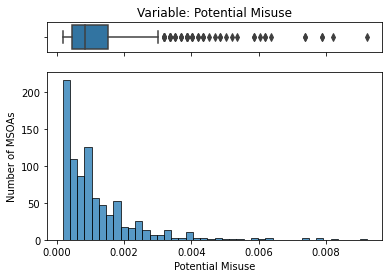

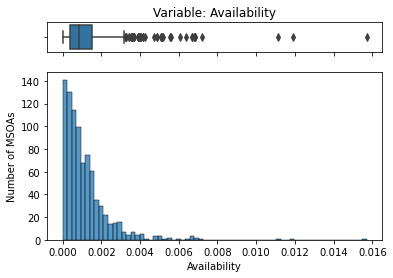

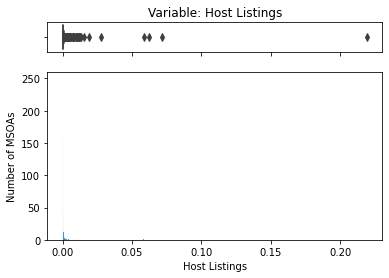

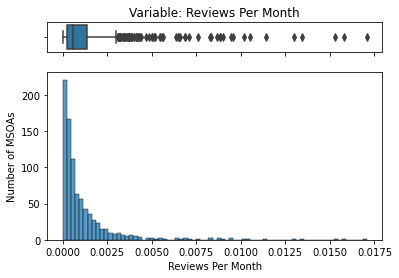

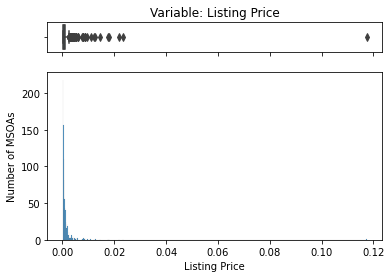

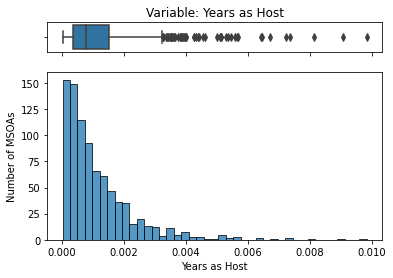

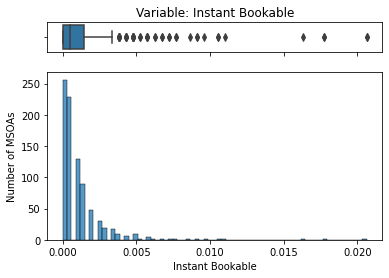

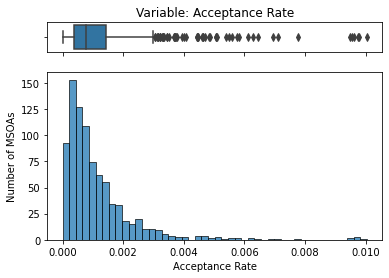

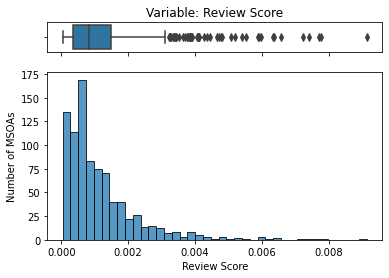

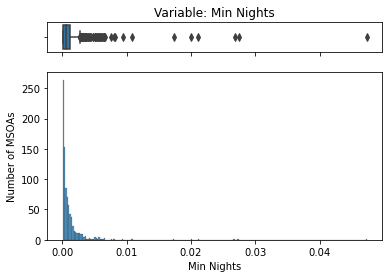

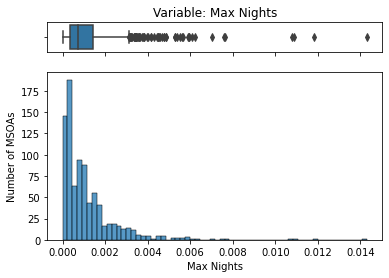

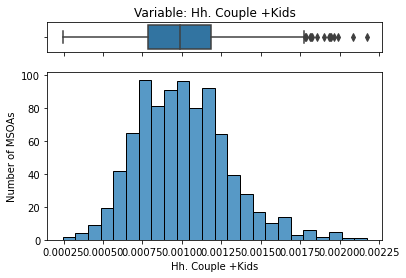

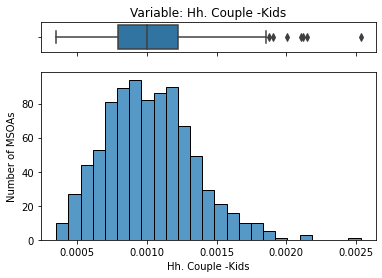

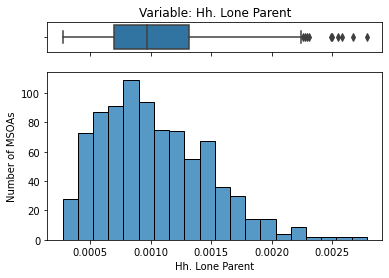

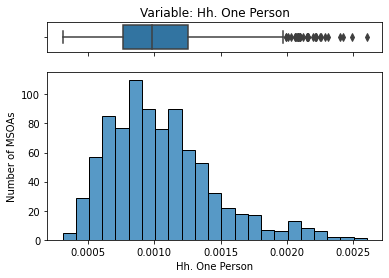

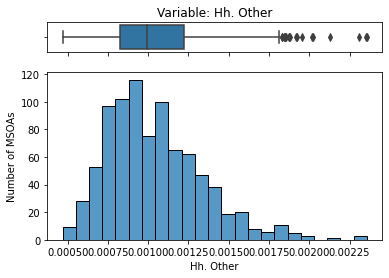

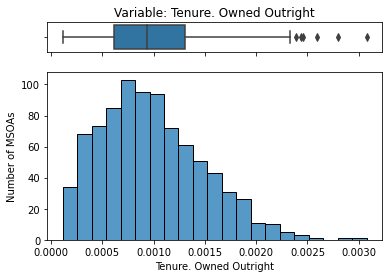

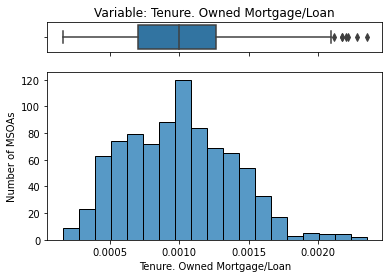

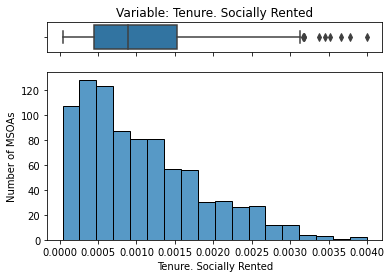

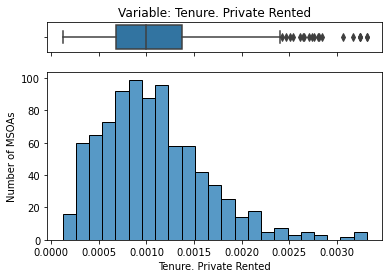

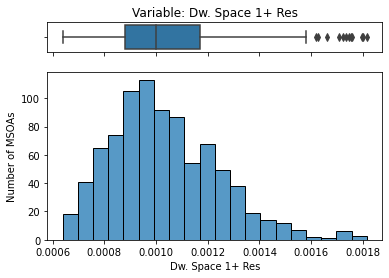

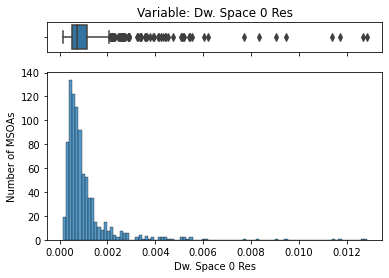

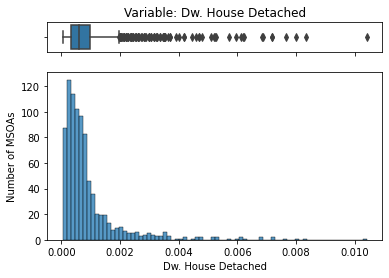

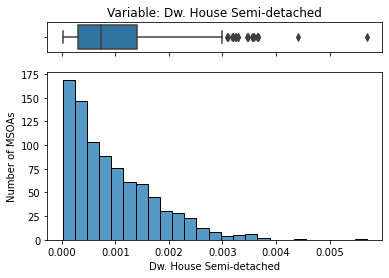

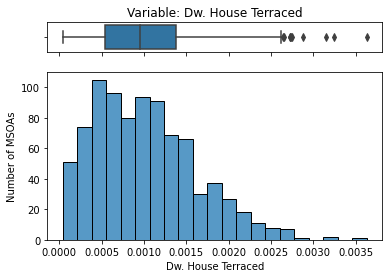

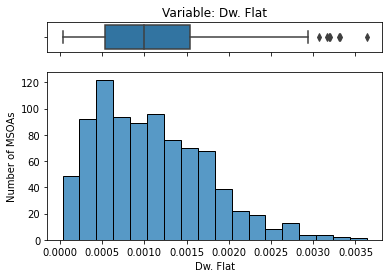

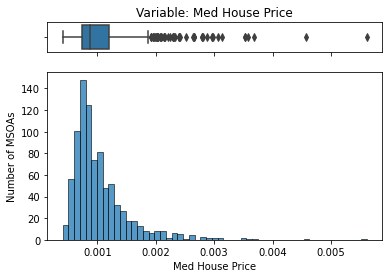

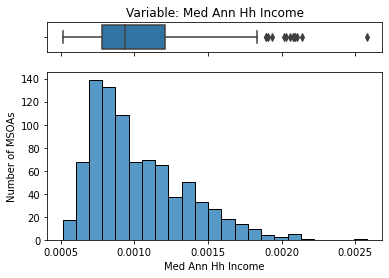

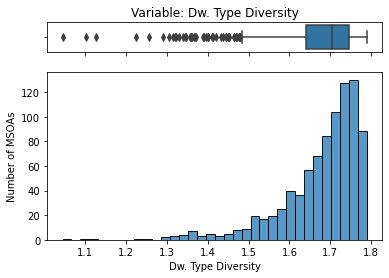

In [24]:
for column in ww[3:6]:
    x = boxhist(ww[column], title = f'Variable: {column}', xlabel= f'Standardised {column}')

#ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
#boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);


# https://stackoverflow.com/questions/28218698/how-to-iterate-over-columns-of-pandas-dataframe-to-run-regression
# https://www.geeksforgeeks.org/get-column-index-from-column-name-of-a-given-pandas-dataframe/

### Transform

In [25]:
### Interquartile Standardisation
from sklearn.preprocessing import RobustScaler

train_r = ww.copy()

# Initialise the Scaler
rbs = RobustScaler(quantile_range=[0.025,0.975])

# Perform standardisation
for c in train_r:
    train_r[c] = rbs.fit_transform(train_r[c].values.reshape(-1,1))

In [26]:
### Yeo-Johnson Transformation
from sklearn.preprocessing import PowerTransformer

train_p = ww.copy()

# Initialise the Transformer
pts = PowerTransformer()

# Perform transformation
for c in train_p:
    train_p[c] = pts.fit_transform(train_p[c].values.reshape(-1,1))

# https://github.com/scikit-learn/scikit-learn/issues/14959

In [27]:
### Range Normalisation
from sklearn.preprocessing import MinMaxScaler

train_m = train_p.copy()

# Initialise the Scaler 
mms = MinMaxScaler(feature_range=(-1,1))

# Rescale the columns 
for c in train_m:
    train_m[c] = mms.fit_transform(train_m[c].values.reshape(-1,1))

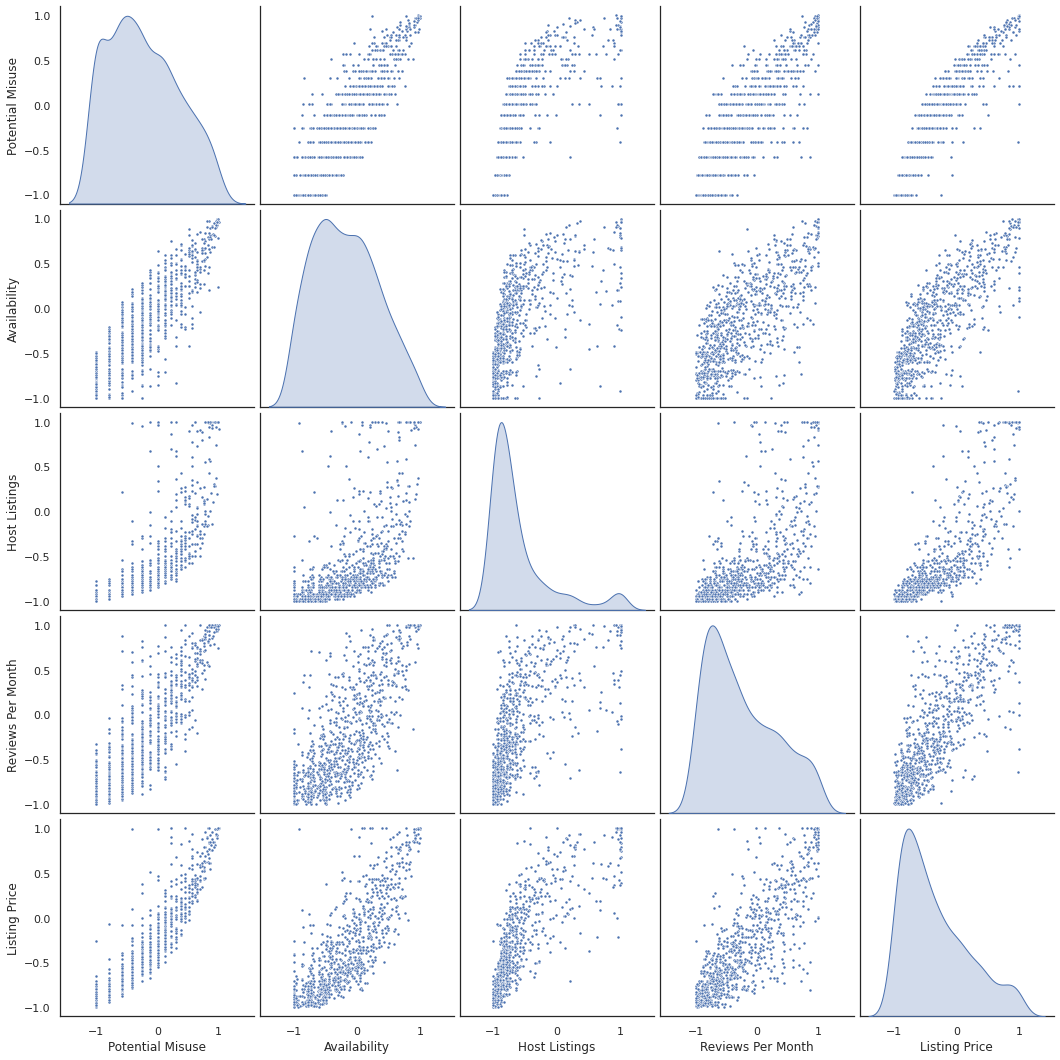

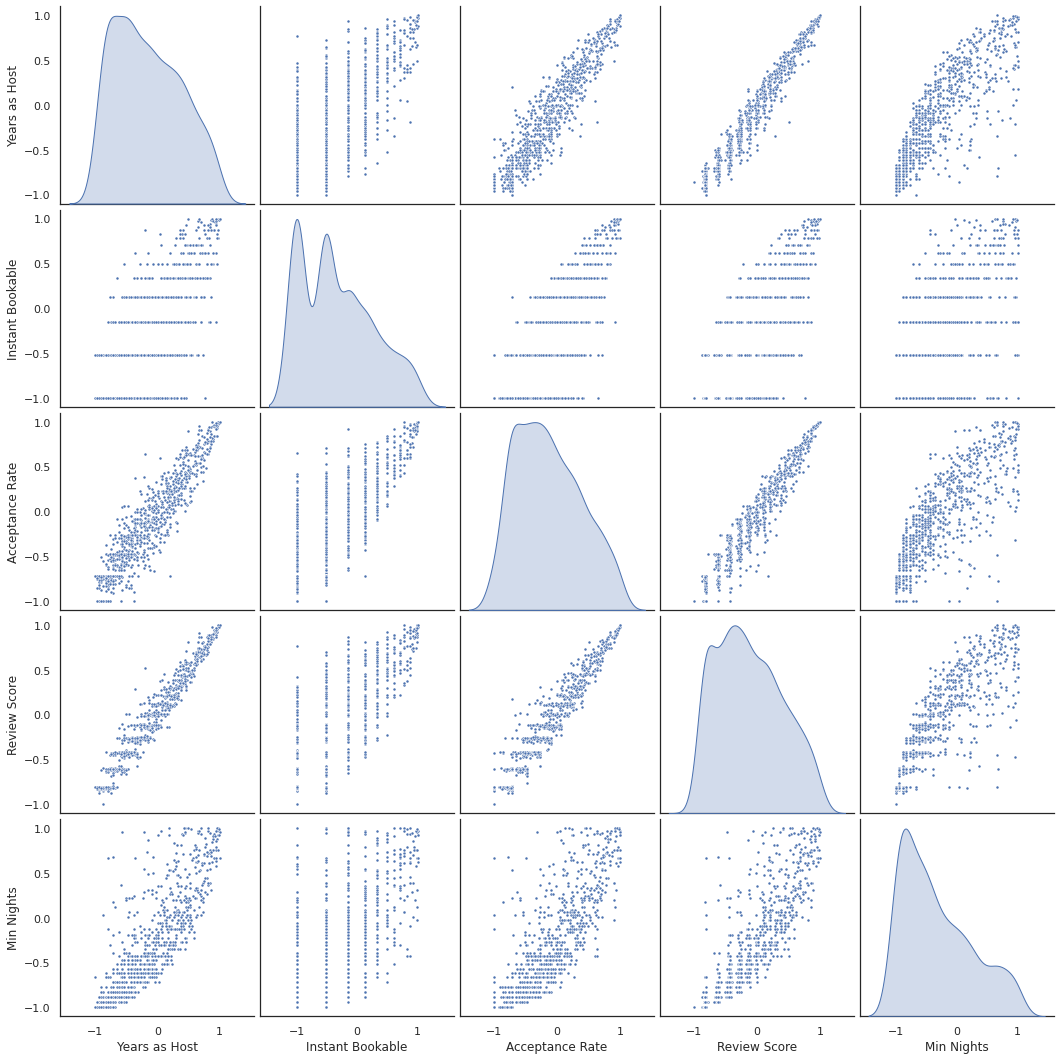

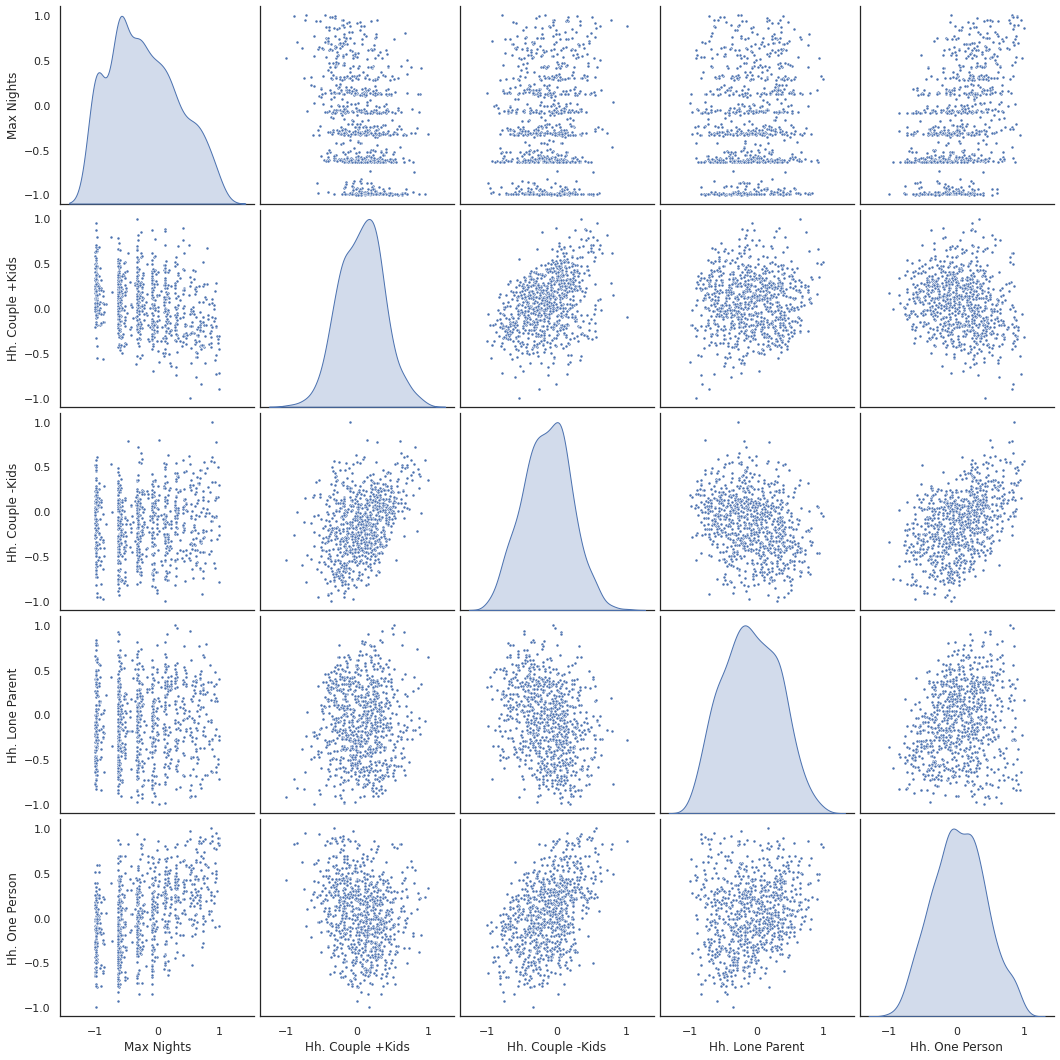

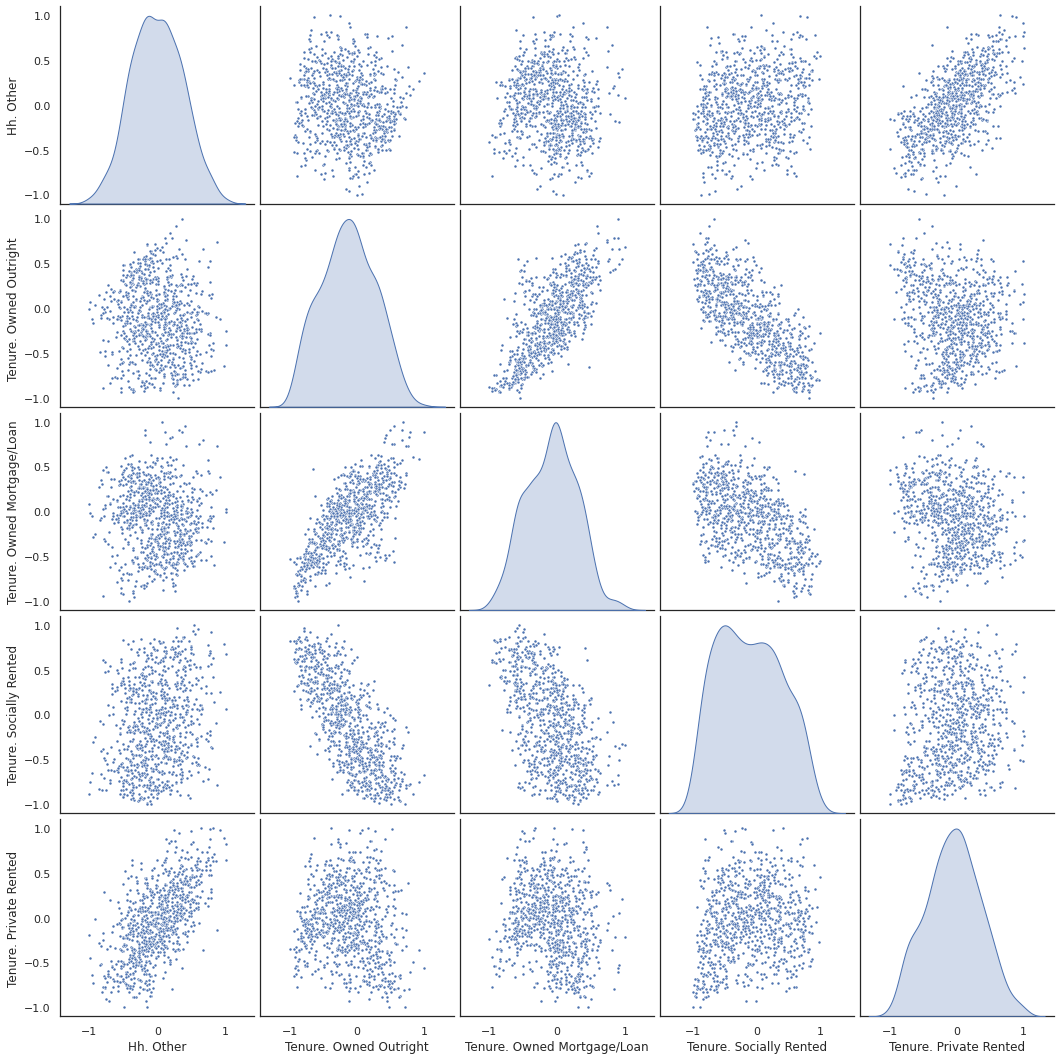

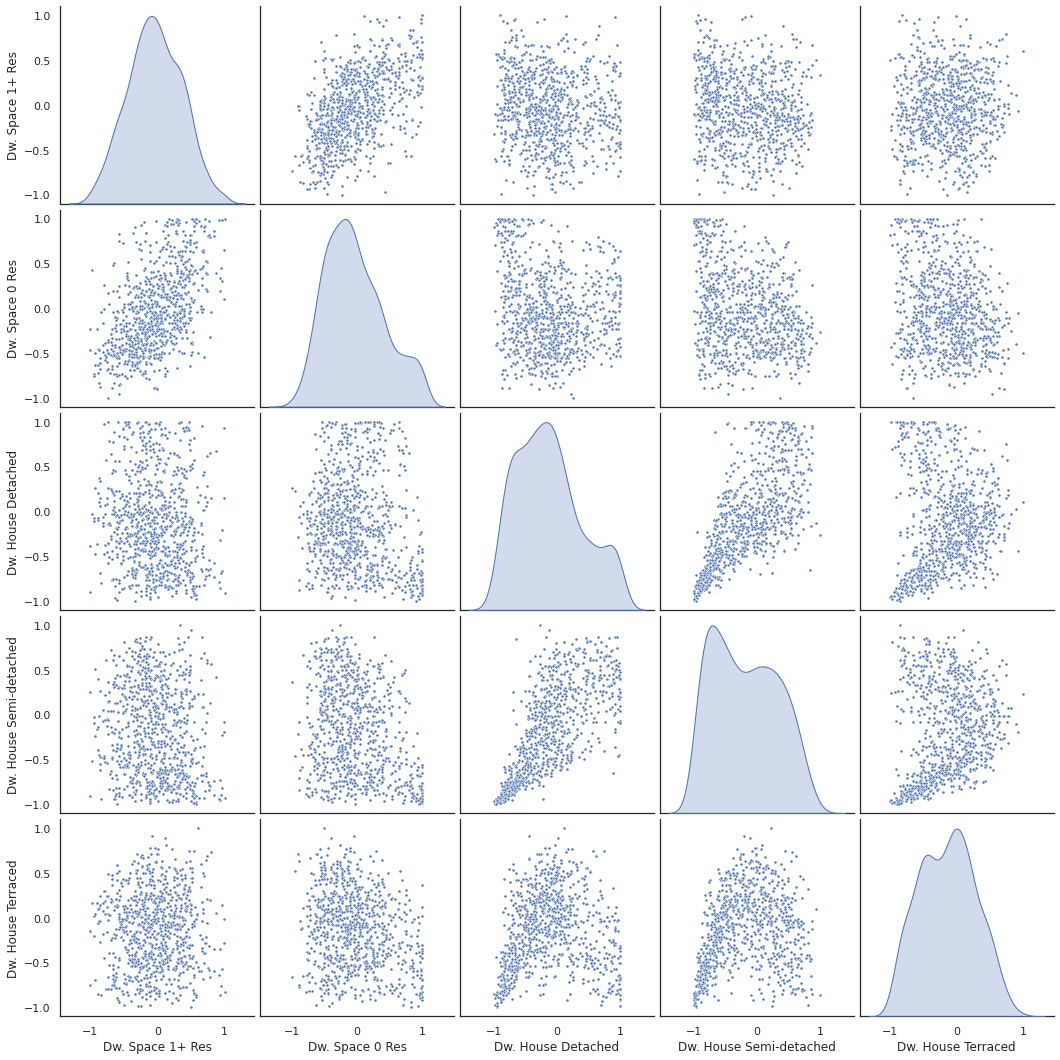

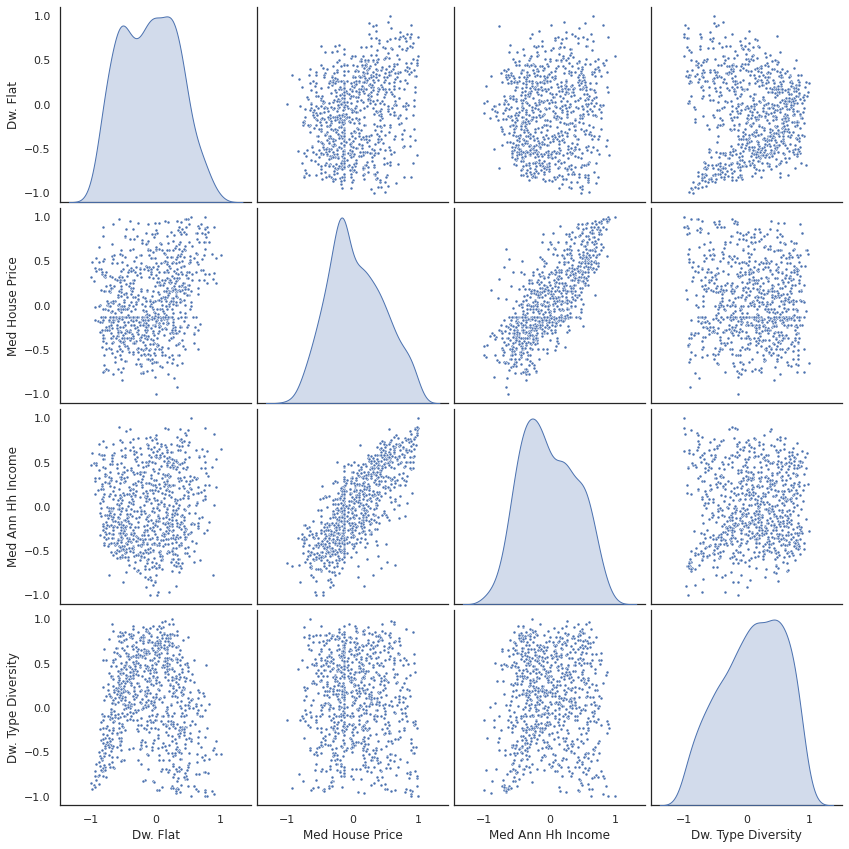

In [28]:
### Plot Range Normalisation Results
sns.set(style="white")
sns.pairplot(train_m.iloc[:,[0,1,2,3,4]], markers=".", height=3, diag_kind='kde');
sns.pairplot(train_m.iloc[:,[5,6,7,8,9]], markers=".", height=3, diag_kind='kde');
sns.pairplot(train_m.iloc[:,[10,11,12,13,14]], markers=".", height=3, diag_kind='kde');
sns.pairplot(train_m.iloc[:,[15,16,17,18,19]], markers=".", height=3, diag_kind='kde');
sns.pairplot(train_m.iloc[:,[20,21,22,23,24]], markers=".", height=3, diag_kind='kde');
sns.pairplot(train_m.iloc[:,[25,26,27,28]], markers=".", height=3, diag_kind='kde');

## Principal Components Analysis (PCA)

In [29]:
from sklearn.decomposition import PCA 

In [30]:
train = train_m.copy()

pca = PCA(n_components=29, whiten=True) 

pca.fit(train)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

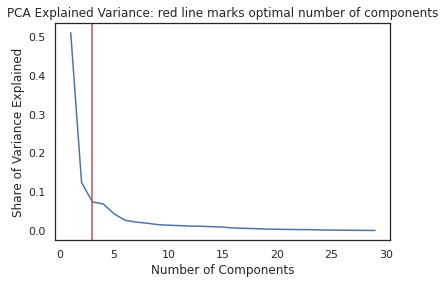

In [31]:
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.axvline(x=3, color='r')
plt.ylabel('Share of Variance Explained')
plt.xlabel('Number of Components')
plt.title('PCA Explained Variance: red line marks optimal number of components')
plt.show()

In [32]:
for i in range(0, 29):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 51.07% of variance
Component  1 accounts for 12.36% of variance
Component  2 accounts for 7.37% of variance
Component  3 accounts for 6.83% of variance
Component  4 accounts for 4.27% of variance
Component  5 accounts for 2.63% of variance
Component  6 accounts for 2.16% of variance
Component  7 accounts for 1.87% of variance
Component  8 accounts for 1.51% of variance
Component  9 accounts for 1.34% of variance
Component 10 accounts for 1.25% of variance
Component 11 accounts for 1.11% of variance
Component 12 accounts for 1.08% of variance
Component 13 accounts for 0.97% of variance
Component 14 accounts for 0.87% of variance
Component 15 accounts for 0.62% of variance
Component 16 accounts for 0.55% of variance
Component 17 accounts for 0.46% of variance
Component 18 accounts for 0.35% of variance
Component 19 accounts for 0.30% of variance
Component 20 accounts for 0.26% of variance
Component 21 accounts for 0.22% of variance
Component 22 accounts for 0.20

In [33]:
#use knee, or keep all components contributing more than 1% of the variance. ---*deterministic* process

keep_n_components = 12
pca = PCA(n_components=keep_n_components, whiten=True)
X_train = pca.fit_transform(train)

for i in range(0, keep_n_components):
    print(f"Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>2.2f}% of variance")

# Notice...
print(len(X_train))
print(train.shape[0])
# So each observation has a row in X_train and there is 
# 1 column for each component. This defines the mapping
# of the original data space into the reduced one
print(len(X_train[0])) 

Component  0 accounts for 51.07% of variance
Component  1 accounts for 12.36% of variance
Component  2 accounts for 7.37% of variance
Component  3 accounts for 6.83% of variance
Component  4 accounts for 4.27% of variance
Component  5 accounts for 2.63% of variance
Component  6 accounts for 2.16% of variance
Component  7 accounts for 1.87% of variance
Component  8 accounts for 1.51% of variance
Component  9 accounts for 1.34% of variance
Component 10 accounts for 1.25% of variance
Component 11 accounts for 1.11% of variance
868
868
12


In [34]:
components = pd.DataFrame(X_train.copy())
components.columns = ['C1', 'C2', 'C3', 'C4', 'C5', 
                      'C6', 'C7', 'C8', 'C9', 'C10', 
                      'C11', 'C12']

In [35]:
gspu = pd.DataFrame(spunit['MSOA11CD'].copy())
gspu['geometry'] = spunit['geometry'].copy()

In [36]:
pcadf = pd.merge(gspu, components, left_index=True, right_index=True, how = 'inner')
pcadf = gpd.GeoDataFrame(pcadf, geometry='geometry')

## K-Means Clustering

In [37]:
from sklearn.cluster import KMeans

In [38]:
# cluster dataframe
cldf = components

# Create a 'result set' (rs) data frame to hold clustering operation results linked to shapefile
res = pd.merge(pcadf, train.reset_index(), left_on = 'MSOA11CD', right_on = 'MSOA11CD', how='inner')

In [39]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

.......................................
Largest silhouette score was 0.1075 for k=8


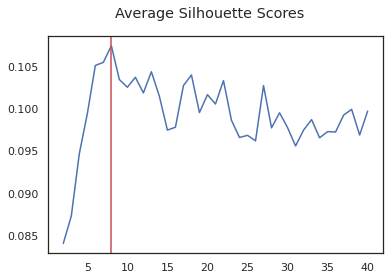

In [40]:
plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");
plt.axvline(x=8, color='r');

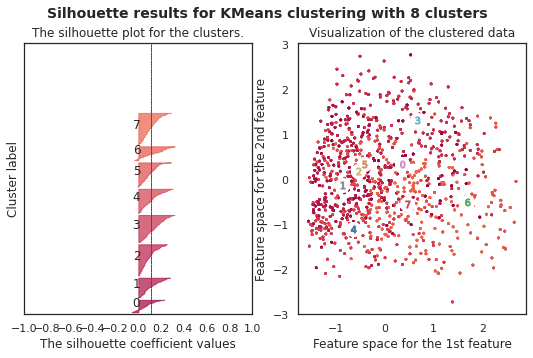

In [41]:
k_pref = 8
c_nm   = 'KMeans' # Clustering name
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)

# We do this for plotting
res[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(cldf, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

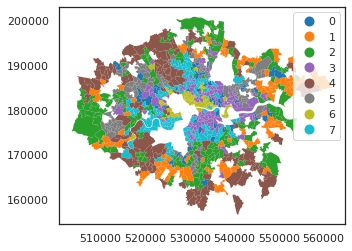

In [42]:
res.plot(column=c_nm, linewidth=0, categorical=True, legend=True); #, ax=ax, zorder=0, 

#clusters_map.savefig(os.path.join('clusters_map.png'), dpi=200)

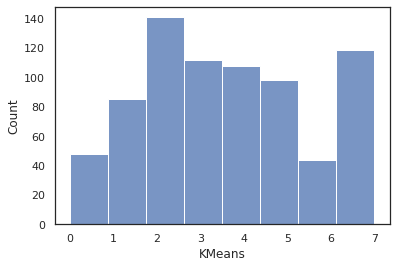

In [43]:
# How are the clusters distributed?
ax = sns.histplot(data=res, x=c_nm, bins=k_pref);

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7


/tmp/ipykernel_220/2972374561.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroids = centroids.append(c.mean(), ignore_index=True)


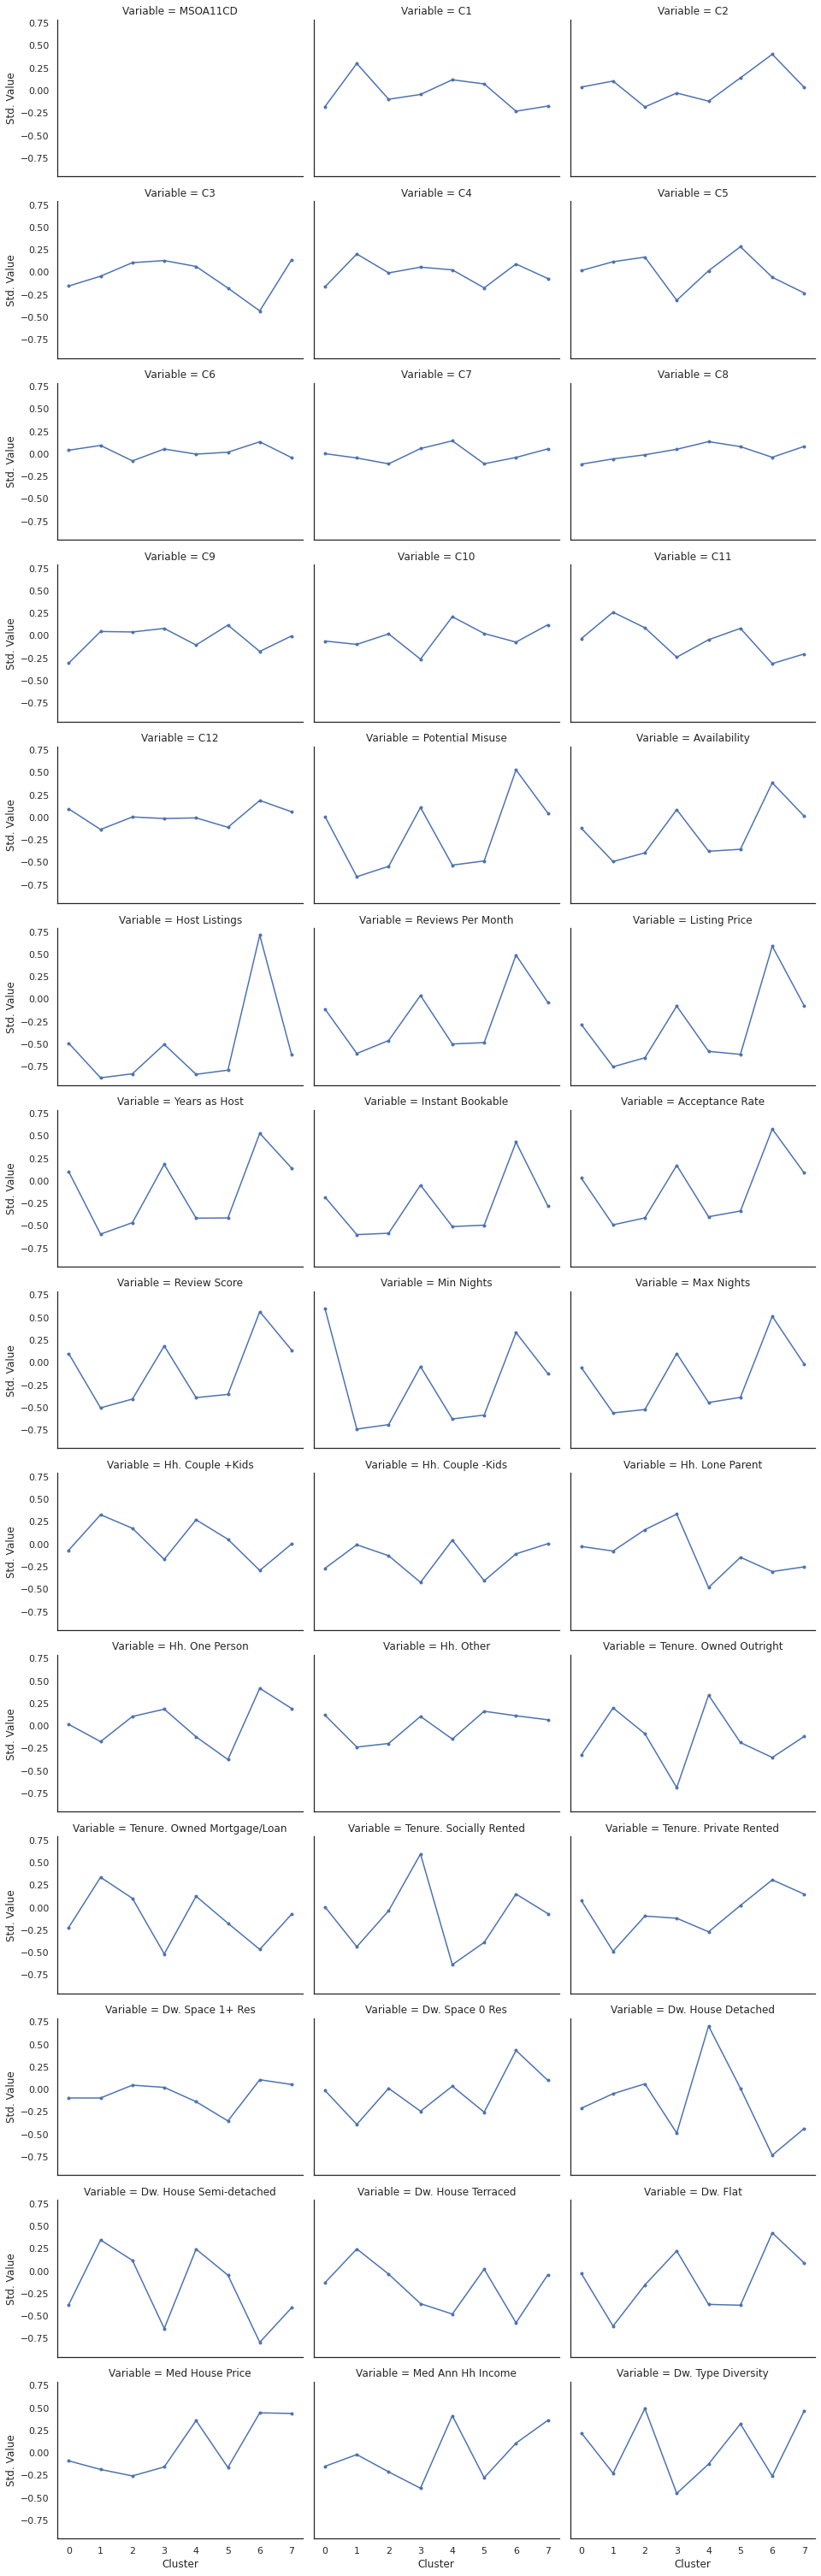

In [44]:
centroids = None
for k in sorted(res[c_nm].unique()):
    print(f"Processing cluster {k}")

    c = res[res[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['Borough','msoa11hclnm','Subregion','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

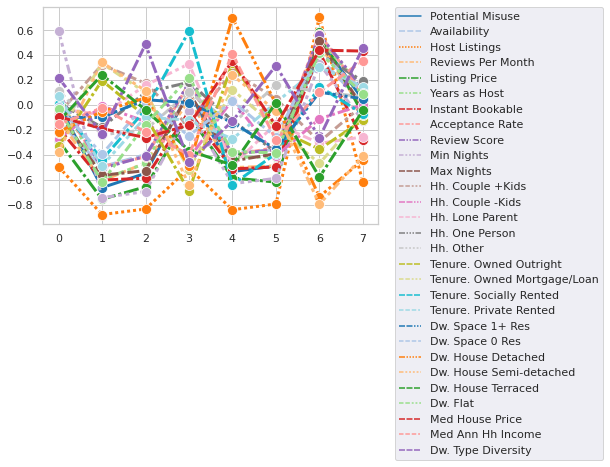

In [45]:
first = keep_n_components + 2
va = res.iloc[:,first:-1].copy()
 
for x in va:
    va[x] = res.groupby('KMeans').agg({x:'mean'} ) 

sns.set_theme(style="whitegrid")
multi = sns.lineplot(data = va, palette="tab20", linewidth=3, marker="o", markersize=10)

# Adjust the tick positions and labels
multi.set(xticks=np.arange(k_pref))
sns.set(rc={'figure.figsize':(11.7,8.27)})
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot

# Put the legend out of the figure
multi.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot

In [46]:
res.dtypes

MSOA11CD                         object
geometry                       geometry
C1                              float64
C2                              float64
C3                              float64
C4                              float64
C5                              float64
C6                              float64
C7                              float64
C8                              float64
C9                              float64
C10                             float64
C11                             float64
C12                             float64
Potential Misuse                float64
Availability                    float64
Host Listings                   float64
Reviews Per Month               float64
Listing Price                   float64
Years as Host                   float64
Instant Bookable                float64
Acceptance Rate                 float64
Review Score                    float64
Min Nights                      float64
Max Nights                      float64


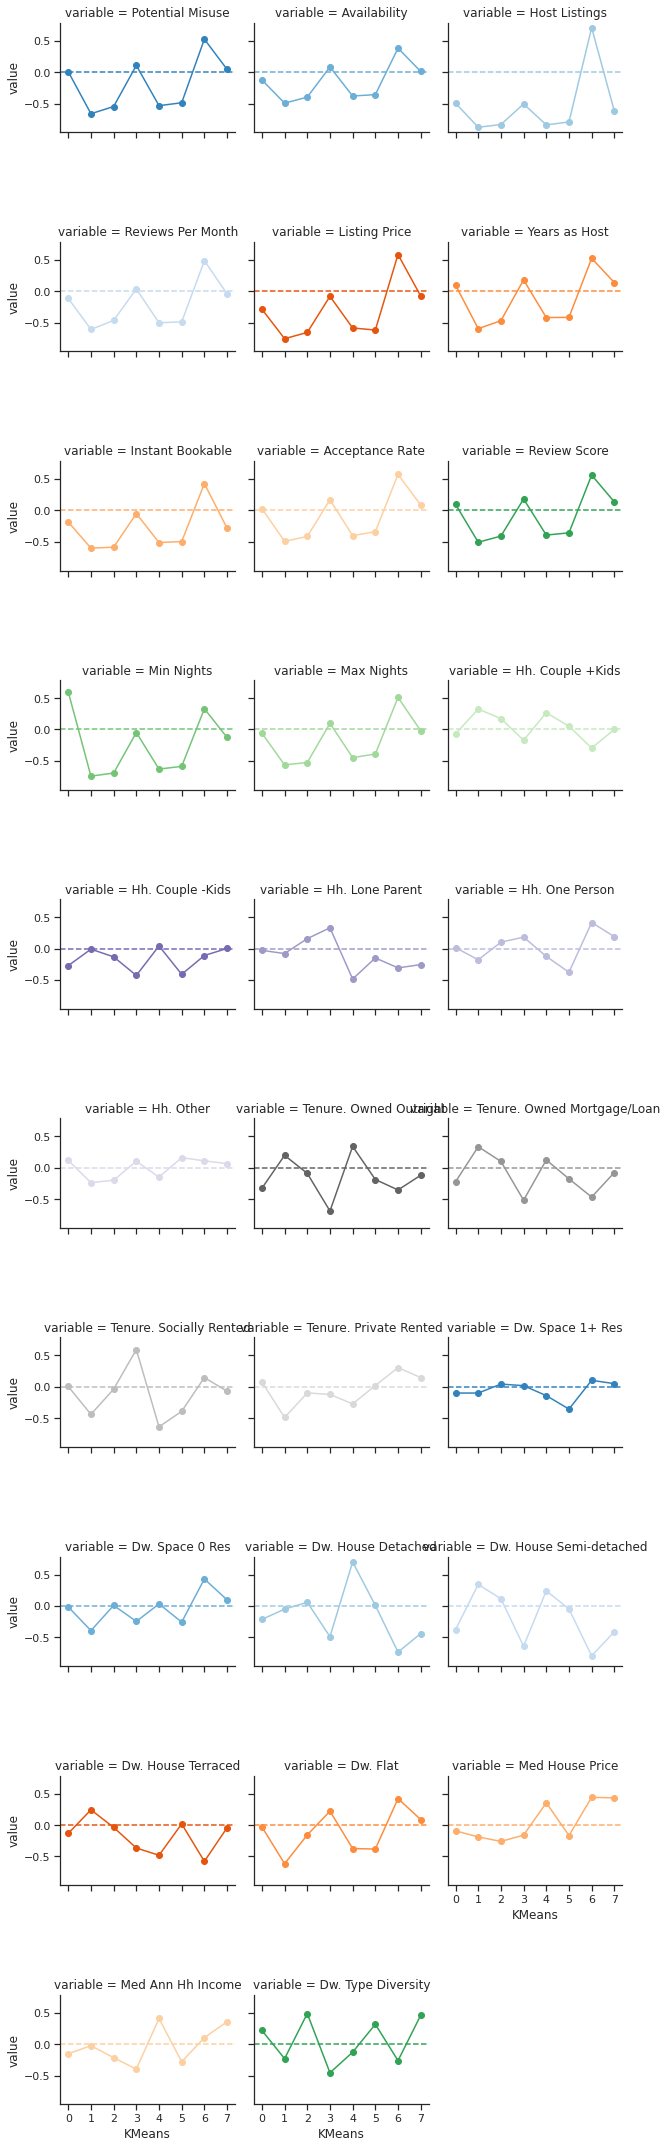

In [47]:
v = res.groupby('KMeans').agg({'Potential Misuse':'mean'} ) 
v.reset_index(inplace=True)
v = v.melt(id_vars=['KMeans'], value_vars=['Potential Misuse'])

second = keep_n_components + 3
for x in res.iloc[:,second:-1]:
    v1 = res.groupby('KMeans').agg({x:'mean'} ) 
    v1.reset_index(inplace=True)
    v1 = v1.melt(id_vars=['KMeans'], value_vars=[x])
    v = pd.concat([v,v1])
    
sns.set_theme(style="ticks")

# Initialize a grid of plots with an Axes for each variable
grid = sns.FacetGrid(v, col = 'variable', hue = 'variable', col_wrap=3, palette="tab20c"); #, height=1.5)

# Draw a horizontal line at y=0
grid.map(plt.axhline, y=0, ls='--' )#, c='red')

# Adjust the tick positions and labels
grid.set(xticks=np.arange(k_pref))

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "KMeans", "value", marker="o")

# Adjust the arrangement of the plots
plt.subplots_adjust(hspace=1)
    
#grid.savefig(os.path.join('outputs','Fig. Variable Means for 8 Clusters.png'), dpi=100)
grid.savefig(os.path.join('clusters_variables.png'), dpi=100)

# https://seaborn.pydata.org/examples/many_facets.html
# https://stackoverflow.com/questions/43669229/increase-space-between-rows-on-facetgrid-plot

# Executive Briefing

## Executive summary

The focus of this study is to gain deeper insight into potential misuse and host characteristics of Airbnb listings for the Mayor of the Greater London Authority by exploring what patterns exist amongst these known associations of potential misuse as well as with factors that distinguish types of Airbnb hosts, if they are spatially patterned, and if they distinguish different host types.

Potential misuse is defined as entire home listings available over 180 days a year, likely to breach the 90-night limit of Section 44 of the Deregulation Act.

Clustering analysis detects eight clusters of potential misuse with perceivable spatial patterning, occurring in regional clusters divided between Inner and Outer London. These clusters represent regional host types that can guide regulation-making and enforcement. Key findings to guide regulation enforcement and policy include:

Local authorities should prioritize enforcing Section 44 of the Deregulation Act within the Inner Clusters (0, 3, 6, 7), where they may target investigating Airbnb host-listings with the following typologies:
- In Cluster 0 – entire-home Airbnb listings with high values of minimum nights 
- In Cluster 6 - entire-home Airbnb listings that are privately rented flats and household spaces
- In Cluster 3 - entire-home Airbnb listings that have socially rented tenure


## Background

Understanding misuse in renting short term accommodations, notably through prevalent online platforms such as Airbnb, may lead to more effective regulation of soaring rental prices in London. 
The idea of misuse arises from the concern that Airbnb host listings decrease the supply of available housing for long-term residents, resulting in rising local rental prices. Recent studies on Airbnb host misuse in London finds Airbnb possibly associated with increasing rents; Shabrina et al. (2022)
 notes how historical deregulations left the challenge of enforcement up to local entities and reveals areas where potential misuse is concentrated. Analysis of spatial patterning can guide targeted policies that minimize resource expenditure and mitigate issues in housing supply and prices. 

Researchers define potential misuse with several factors. First is offering entire home/apartment listings; while not illegal, it can directly reduce the available housing supply for long-term renters. Second, providing compensated temporary sleeping accommodation exceeding ninety nights per year breaches regulations (Explanatory Notes to Deregulation Act 2015). Shabrina et al. (2022) uses both these in their definition, estimates the likelihood of the latter in terms of listings offered over 180 days a year, and considers hosts having multiple listings as a further layered definition. Another concept, host professionalism, is like the idea of misuse. Xie et al. (2021) finds that both types of professional hosts, multi-listing hosts and full-time hosts (offering at least full month rentals), make more than 20% revenue per night than single-listing and part-time hosts, respectively in California. Based on this terminology, professional hosts renting listings as "micro-entrepreneurs" are related to potential misuse (Xie et al., 2021). 

Current research has looked at factors relating to where potential misuse is concentrated and has gained some perspectives on Airbnb host characteristics. For example, potential misuse is associated with areas of low dwelling-type diversity comprised of flats and apartments, private-rented properties, rental increase, and middle-income /post-gentrified areas (Shabrina et al., 2022). On the other hand, studies have found that Airbnb host motivation is to supplement rent or mortgage payments, hinting at a vicious cycle of paying rent off and racking up rent (Ikkala and Lampinen, 2015). Also, professional may be more likely to leave the market (Shabrina et al., 2022). Inspired by these studies, this report explores what patterns exist amongst these known associations of potential misuse as well as with factors that distinguish types of Airbnb hosts, if they are spatially patterned, and if they distinguish different host types. 


## Data Analysis

Cluster analysis allows a reexamining of many variables found significant in previous studies with the addition of host-related variables. This clustering approach is ideal for identifying patterns and subgroups amongst variables, such as detecting host- and misuse- related groupings. Several variables used in this investigation are associated with definitions of misuse. I also add factors that may help categorize identify hosts through their behaviors and tendencies. However, I subset the variables to include only potential misuse listings, defined as professional full-time hosts offering entire home listings over 180+ days a year, as previous studies have chosen this to reflect possibility of breaching 90-night regulation (Shabrina et al., 2022). Thus, rather than detecting misuse, I evaluate types of misuse and host characteristics.

My primary data sources for clustering variables are October 2021 Inside Airbnb data for London and 2011 MSOA census data for London (MSOA Atlas).  I use MSOA as my spatial unit because it provides local specificity useful for regulation-making and provides a different perspective to Shabrina et al. (2022); my reproducible analysis is adaptable for finer LSOA analysis. Community activist Murray Cox scrapes Inside Airbnb data from Airbnb’s website and adds a few calculated columns (Inside Airbnb). Since there is a decade’s difference between the data sources, my analysis assumes that patterns from the past are linked to patterns today. In preparing my variables for comparison, I proportion them by aggregating the variable counts per spatial unit and divided variable counts London-wide, thereby removing the artificial weighting caused by unequal, irregular spatial units. Shabrina et al. (2022) treat their dwelling type data similarly. Using Shannon’s entropy on treated variables, I also include dwelling type diversity, which Shabrina et al. (2022) find associated with misuse. 

The summary statistics for the 29 variables show many strongly skewed distributions, so I apply Yeo-Johnson Transformation and subsequent range normalization. Host listing is one such highly skewed distribution; although excluding single listings hosts provides a stricter definition of misuse, I retain single listings hosts, since they can perpetrate the 90-night regulation, and considered host listings as a continuous range variable. Understanding that the Host Listings variable may contain exponential counts of multiple host listings, since multiple listings hosts will be counted for each of their listings, I did not remove any of its outliers. It is a dramatic metric that future studies may choose treat differently.

Principal Components Analysis (PCA) provided dimensionality reduction of the variables. At its knee, the Explained Variance plot indicated only three components to be optimal, the 1% explained variance threshold was adopted instead, arriving at twelve components as the optimal threshold for dimensionality reduction. 

Finally, K-Means, a computationally efficient method of clustering, which yielded the largest silhouette score for eight clusters. Similar patterns of clustering for variable subgroups help describe these clusters of potential misuse. Airbnb variables have clustered similarly, as well as couples/owned/house variables, with values oppositional to Airbnb values. Housing price/income is another grouping, while single adult households, other households, dwelling Spaces, flats, and dwelling type diversity have unique clustering patterns.


![Variable Means for 8 Clusters](clusters_variables.png)

## Conclusion

Clustering analysis detects eight clusters of potential misuse with spatial patterning, occurring in regional clusters divided between Inner and Outer London. These clusters represent regional host types that can guide regulation-making and enforcement. MSOAs with no potential misuse listings will need less attention from authorities. Since K-Means is sensitive to skew, one limitation is that Yeo-Johnson Transformation outputs retaining skew may over-influence clustering results. Homogeneity of Airbnb patterning may show the strength of these variables as positive indicators for the Inner/Outer divide but may also reflect their correlation or that other variables are over-influential. Clustering only Airbnb variables might also locate further types of professional hosts; for example, Xie et al. (2021) found that customer evaluations affected full-time hosts more than multi-listing hosts. Finally, replicating this study for all Airbnb listings can check if these clusters are unique to the misuse subset.

Inner Clusters (0, 3, 6, 7) have high Airbnb/Rented/Flat values, signifying popularity in the Airbnb marketplace, and low Couples/Owned/House values:
- While Cluster 0 has fewer listings and is more spatially scattered, it has the strongest deviation in Airbnb variable patterning: Airbnb hosts here require high Minimum Nights. Local authorities should focus Section 44 enforcement in this area, where there may be more long-time guests.
- Cluster 6 is a small area in central London but has the highest values of all clusters for Airbnb variables, median house price, and other variables. In these MSOAs, authorities should target Section 44 enforcement on private rented flats and dwelling spaces with no usual residents or one person households.
- In Cluster 3, focus Section 44 enforcement on Socially Rented tenure. 
- Cluster 7 contains high house prices and incomes in high dwelling type diversity areas. Lacking specific insight, authorities may prioritize other areas.

Outer Clusters (1, 2, 4, 5) have high Couples/Owned/House values. Hosts may more likely have families here. With the lowest Airbnb/Rented/Flat values, this study recommends these clusters for lower priority attention.
- Cluster 1 has many couples with kids, high property ownership, high semi-detached and terraced houses, and low dwelling type diversity. 
- Cluster 2 is a lower income area with couples with kids, lone parents, and detached and semi-detached houses. 
- Cluster 4 stands is a high income, high house price area with numerous couples with and without children, detached and semi-detached houses, and high property ownership. 
- Cluster 5 is a low income, low house price area with high dwelling type diversity.


# Bibliography

[Explanatory Notes to Deregulation Act 2015. Queen’s Printer of Acts of Parliament. (Accessed: 11 January 2022).](https://www.legislation.gov.uk/ukpga/2015/20/notes/division/5/46)

[Ikkala, T. and Lampinen, A. (2015) ‘Monetizing Network Hospitality: Hospitality and Sociability in the Context of Airbnb’, in Proceedings of the 18th ACM Conference on Computer Supported Cooperative Work & Social Computing. New York, NY, USA: Association for Computing Machinery (CSCW ’15), pp. 1033–1044.](doi:10.1145/2675133.2675274)

[Inside Airbnb. Adding data to the debate. (no date) Inside Airbnb. (Accessed: 11 January 2022).](http://insideairbnb.com)

[‘MSOA Atlas - London Datastore’ (no date). (Accessed: 11 January 2022).](https://data.london.gov.uk/dataset/msoa-atlas)

[python - Matplotlib: Can we draw a histogram and a box plot on a same chart? (no date) Stack Overflow. (Accessed: 11 January 2022).](https://stackoverflow.com/questions/12127635/matplotlib-can-we-draw-a-histogram-and-a-box-plot-on-a-same-chart)

[Shabrina, Z., Arcaute, E. and Batty, M. (2022) ‘Airbnb and its potential impact on the London housing market’, Urban Studies, 59(1), pp. 197–221.](doi:10.1177/0042098020970865)

[‘Statistical GIS Boundary Files for London - London Datastore’ (no date). (Accessed: 11 January 2022).](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london)

[Xie, K., Heo, C.Y. and Mao, Z.E. (2021) ‘Do professional hosts matter? Evidence from multi-listing and full-time hosts in Airbnb’, Journal of Hospitality and Tourism Management, 47, pp. 413–421.](doi:10.1016/j.jhtm.2021.04.016)